# Tyre Quality Classification

## initialization variable

In [1]:
import os
import torch
import pathlib
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn import functional as F
torch.set_default_dtype(torch.float32)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 32 

## Loss Function

In [2]:
def cross_entropy(y_pred, y_true):
    ce_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    return ce_loss

## Network model

A neural network with double convolution injection learning mechanism for binary classification problems

In [3]:
class ClassificationDigitalNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ClassificationDigitalNet, self).__init__()
        self.bc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)  
        )
        self.attention = nn.Sequential(
            nn.Linear(128 * 64 * 64, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 64 * 64, num_classes)
        )

    def forward(self, x):
        x = self.bc(x)
        x_flat = x.view(x.size(0), -1)
        attention_weights = self.attention(x_flat)
        x_attended = attention_weights.view(x.size(0), -1) * x_flat
        out = self.classifier(x_attended)
        return out

# The model is improved to an ensemble model

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, 2)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.normal_model = ClassificationDigitalNet(num_classes)
        self.residual_model = ResNet(num_classes)
        self.fc1 = nn.Linear(num_classes * 2, 512) 
        self.dropout1 = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(512, 256) 
        self.dropout2 = nn.Dropout(0.5)  
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        normal_output = self.normal_model(x)
        residual_output = self.residual_model(x)
        combined_output = torch.cat((normal_output, residual_output), dim=1)
        combined_output = self.fc1(combined_output)
        combined_output = nn.functional.relu(combined_output)
        combined_output = self.dropout1(combined_output)
        combined_output = self.fc2(combined_output)
        combined_output = nn.functional.relu(combined_output)
        combined_output = self.dropout2(combined_output)
        final_output = self.fc3(combined_output)
        return final_output

## data loading

In [5]:
class Digital(Dataset):  
    def __init__(self, path):
        super(Digital, self).__init__()
        data_root = pathlib.Path(path)
        all_image_paths = list(data_root.glob('*/*'))
        self.all_image_paths = [str(path) for path in all_image_paths]
        label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
        label_to_index = dict((label, index) for index, label in enumerate(label_names))
        print(label_to_index)
        self.all_image_labels = [label_to_index[path.parent.name] for path in all_image_paths]
        self.mean = np.array(mean).reshape((1, 1, 3))
        self.std = np.array(std).reshape((1, 1, 3))

    def __getitem__(self, index):
        img = cv.imread(self.all_image_paths[index])
        img = cv.resize(img, (256, 256))
        img = img / 511.
        img = (img - self.mean) / self.std
        img = np.transpose(img, [2, 0, 1])
        label = self.all_image_labels[index]
        img = torch.tensor(img, dtype=torch.float32)
        label = torch.tensor(label)
        return img, label

    def __len__(self):
        return len(self.all_image_paths)

In [6]:
data = Digital("./Digital images of defective and good condition tyres")
""" Splitting the dataset """
train_size = int(len(data) * 0.7)  
vaild_size = int(len(data) * 0.15)  
test_size = len(data) - train_size - vaild_size  
train_dataset, vaild_dataset, test_dataset = random_split(data, [train_size, vaild_size, test_size],
                                                          generator=torch.Generator().manual_seed(0)) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
validate_loader = DataLoader(vaild_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

{'defective': 0, 'good': 1}


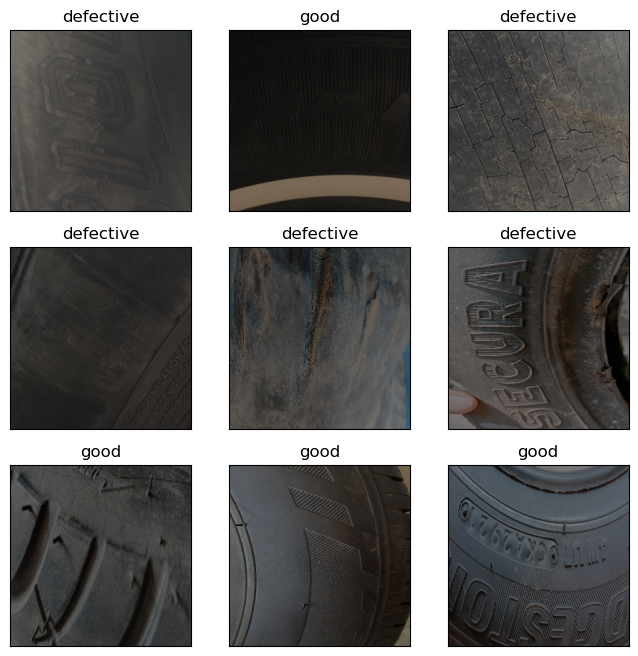

In [7]:
import random
from matplotlib import pyplot as plt


def denorm(img):
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    img = torch.clamp(img, 0., 1.)
    return img


plt.figure(figsize=(8, 8))
for i in range(9):
    img, label = train_dataset[random.randint(0, len(train_dataset))]
    img = denorm(img)
    img = img.permute(1, 2, 0)
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy()[:, :, ::-1])
    ax.set_title(f"{'good' if label else  'defective'}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 网络初始化

In [8]:
def score(y_pred, y_true):
    y_pred = y_pred.cpu().detach().numpy() if y_pred.is_cuda else y_pred.detach().numpy()
    y_true = y_true.cpu().detach().numpy() if y_true.is_cuda else y_true.detach().numpy()

    tp = (y_pred[(y_true == 1)]).sum()
    tn = (y_pred[(y_true == 0)]).sum()
    fp = ((y_pred == 1)[(y_true == 0)]).sum()
    fn = ((y_pred == 0)[(y_true == 1)]).sum()

    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else (tp + tn + fp + fn)
    pre = tp / (tp + fp) if (tp+fp) else (tp+fp)
    recall =  tp / (tp + fn) if (tp+fn) else (tp+fn)
    return acc, pre, recall

In [9]:
device = torch.device("cpu") 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
if device == "cuda:0":
    torch.cuda.set_per_process_memory_fraction(1.0)

In [10]:
"""Loading the model"""
PATH = "Digital.pth"
model = Net(2).to(device)
if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9) 

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                              verbose=True, threshold=1e-4)

model.train()
train_losses = []
train_precisions = []
train_recalls = []
train_accs = []


vail_accs = []
vail_losses = []

vail_precisions = []
vail_recalls = []


for epoch in range(50): 
    train_loss = []
    train_precision = []
    train_recall = []
    train_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).to(device)  
        optimizer.zero_grad()
        loss = cross_entropy(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc, precision, recall = score(predicted, labels)  
        train_acc.append(acc)  
        train_precision.append(precision) 
        train_recall.append(recall) 
        train_loss.append(loss.cpu().detach().numpy()) 
        loss.backward()
        optimizer.step()
        print("epoch:{}, batch:{}, loss:{}".format(epoch, i, loss))
    total = 0
    correct = 0
    
    vail_loss = []
    vail_precision = []
    vail_recall = []
    vail_acc = []
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = cross_entropy(pred, labels) 
            _, predicted = torch.max(pred, 1)
            acc, precision, recall = score(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            vail_acc.append(acc)
            vail_precision.append(precision)
            vail_recall.append(recall)
            vail_loss.append(loss.cpu().detach().numpy())
        
        scheduler.step( sum(vail_loss) / len(vail_loss))

            
    print("batch:{},auc:{}%".format(total, correct / total * 100))
    train_losses.append(sum(train_loss) / len(train_loss))
    train_precisions.append(sum(train_precision) / len(train_precision))
    train_recalls.append(sum(train_recall) / len(train_recall))
    train_accs.append(sum(train_acc) / len(train_acc))
    
    vail_losses.append(sum(vail_loss) / len(vail_loss))
    vail_precisions.append(sum(vail_precision) / len(vail_precision))
    vail_recalls.append(sum(vail_recall) / len(vail_recall))
    vail_accs.append(sum(vail_acc) / len(vail_acc))

epoch:0, batch:0, loss:0.7119221091270447
epoch:0, batch:1, loss:0.7148119211196899
epoch:0, batch:2, loss:0.6989045739173889
epoch:0, batch:3, loss:0.6823710203170776
epoch:0, batch:4, loss:0.6821510791778564
epoch:0, batch:5, loss:0.6787751317024231
epoch:0, batch:6, loss:0.7076790928840637
epoch:0, batch:7, loss:0.6909922957420349
epoch:0, batch:8, loss:0.6871291995048523
epoch:0, batch:9, loss:0.6916726231575012
epoch:0, batch:10, loss:0.6872695684432983
epoch:0, batch:11, loss:0.6687636375427246
epoch:0, batch:12, loss:0.6931431889533997
epoch:0, batch:13, loss:0.6841728091239929
epoch:0, batch:14, loss:0.6961713433265686
epoch:0, batch:15, loss:0.6734914779663086
epoch:0, batch:16, loss:0.6955024600028992
epoch:0, batch:17, loss:0.6975062489509583
epoch:0, batch:18, loss:0.6968134641647339
epoch:0, batch:19, loss:0.6945546269416809
epoch:0, batch:20, loss:0.7226963043212891
epoch:0, batch:21, loss:0.6510430574417114
epoch:0, batch:22, loss:0.6967486143112183
epoch:0, batch:23, lo

epoch:4, batch:25, loss:0.6554433107376099
epoch:4, batch:26, loss:0.633483350276947
epoch:4, batch:27, loss:0.5845614075660706
epoch:4, batch:28, loss:0.5791910886764526
epoch:4, batch:29, loss:0.5663024187088013
epoch:4, batch:30, loss:0.6910894513130188
epoch:4, batch:31, loss:0.5634449124336243
epoch:4, batch:32, loss:0.5222787261009216
epoch:4, batch:33, loss:0.6022045016288757
epoch:4, batch:34, loss:0.66985023021698
epoch:4, batch:35, loss:0.4998154640197754
epoch:4, batch:36, loss:0.693368136882782
epoch:4, batch:37, loss:0.6394245624542236
epoch:4, batch:38, loss:0.6581608653068542
epoch:4, batch:39, loss:0.7018544673919678
epoch:4, batch:40, loss:0.6173757910728455
batch:278,auc:66.18705749511719%
epoch:5, batch:0, loss:0.6259171366691589
epoch:5, batch:1, loss:0.5969990491867065
epoch:5, batch:2, loss:0.593047022819519
epoch:5, batch:3, loss:0.6102244853973389
epoch:5, batch:4, loss:0.5763660669326782
epoch:5, batch:5, loss:0.5131736993789673
epoch:5, batch:6, loss:0.5585031

epoch:9, batch:8, loss:0.4216417968273163
epoch:9, batch:9, loss:0.3986440598964691
epoch:9, batch:10, loss:0.43084192276000977
epoch:9, batch:11, loss:0.40957343578338623
epoch:9, batch:12, loss:0.42238956689834595
epoch:9, batch:13, loss:0.4339674711227417
epoch:9, batch:14, loss:0.5076832175254822
epoch:9, batch:15, loss:0.5325076580047607
epoch:9, batch:16, loss:0.5504128932952881
epoch:9, batch:17, loss:0.4779525697231293
epoch:9, batch:18, loss:0.5671670436859131
epoch:9, batch:19, loss:0.5571569204330444
epoch:9, batch:20, loss:0.5013399124145508
epoch:9, batch:21, loss:0.4252482056617737
epoch:9, batch:22, loss:0.4733693599700928
epoch:9, batch:23, loss:0.5129277110099792
epoch:9, batch:24, loss:0.39279383420944214
epoch:9, batch:25, loss:0.41471099853515625
epoch:9, batch:26, loss:0.5212393999099731
epoch:9, batch:27, loss:0.29727810621261597
epoch:9, batch:28, loss:0.3794936537742615
epoch:9, batch:29, loss:0.35524964332580566
epoch:9, batch:30, loss:0.39470532536506653
epoch

epoch:13, batch:28, loss:0.3501085340976715
epoch:13, batch:29, loss:0.20809023082256317
epoch:13, batch:30, loss:0.2603931427001953
epoch:13, batch:31, loss:0.24814598262310028
epoch:13, batch:32, loss:0.17532336711883545
epoch:13, batch:33, loss:0.25175032019615173
epoch:13, batch:34, loss:0.27406784892082214
epoch:13, batch:35, loss:0.16593536734580994
epoch:13, batch:36, loss:0.29878896474838257
epoch:13, batch:37, loss:0.2326963245868683
epoch:13, batch:38, loss:0.30044546723365784
epoch:13, batch:39, loss:0.5221215486526489
epoch:13, batch:40, loss:0.19317980110645294
batch:278,auc:82.37409973144531%
epoch:14, batch:0, loss:0.2312220335006714
epoch:14, batch:1, loss:0.3629963994026184
epoch:14, batch:2, loss:0.46770936250686646
epoch:14, batch:3, loss:0.2314566969871521
epoch:14, batch:4, loss:0.3346233367919922
epoch:14, batch:5, loss:0.4714374244213104
epoch:14, batch:6, loss:0.16902858018875122
epoch:14, batch:7, loss:0.1531030833721161
epoch:14, batch:8, loss:0.17357233166694

epoch:18, batch:5, loss:0.3597375452518463
epoch:18, batch:6, loss:0.1519063115119934
epoch:18, batch:7, loss:0.25013139843940735
epoch:18, batch:8, loss:0.21675635874271393
epoch:18, batch:9, loss:0.21993130445480347
epoch:18, batch:10, loss:0.23110012710094452
epoch:18, batch:11, loss:0.16124045848846436
epoch:18, batch:12, loss:0.22402717173099518
epoch:18, batch:13, loss:0.2648846507072449
epoch:18, batch:14, loss:0.05662470683455467
epoch:18, batch:15, loss:0.2167632281780243
epoch:18, batch:16, loss:0.16669659316539764
epoch:18, batch:17, loss:0.275561660528183
epoch:18, batch:18, loss:0.15590597689151764
epoch:18, batch:19, loss:0.34330520033836365
epoch:18, batch:20, loss:0.20980650186538696
epoch:18, batch:21, loss:0.32879638671875
epoch:18, batch:22, loss:0.16503684222698212
epoch:18, batch:23, loss:0.27126970887184143
epoch:18, batch:24, loss:0.15084616839885712
epoch:18, batch:25, loss:0.396878182888031
epoch:18, batch:26, loss:0.3877713084220886
epoch:18, batch:27, loss:0.

epoch:22, batch:22, loss:0.06428743898868561
epoch:22, batch:23, loss:0.15880219638347626
epoch:22, batch:24, loss:0.13749751448631287
epoch:22, batch:25, loss:0.232325479388237
epoch:22, batch:26, loss:0.06966611742973328
epoch:22, batch:27, loss:0.09012880176305771
epoch:22, batch:28, loss:0.24861788749694824
epoch:22, batch:29, loss:0.17043757438659668
epoch:22, batch:30, loss:0.13310953974723816
epoch:22, batch:31, loss:0.06553033739328384
epoch:22, batch:32, loss:0.17881828546524048
epoch:22, batch:33, loss:0.07230246812105179
epoch:22, batch:34, loss:0.050847552716732025
epoch:22, batch:35, loss:0.2267409712076187
epoch:22, batch:36, loss:0.06699670106172562
epoch:22, batch:37, loss:0.06751001626253128
epoch:22, batch:38, loss:0.20515762269496918
epoch:22, batch:39, loss:0.12262433767318726
epoch:22, batch:40, loss:0.0659458264708519
batch:278,auc:87.41007232666016%
epoch:23, batch:0, loss:0.12176801264286041
epoch:23, batch:1, loss:0.15569084882736206
epoch:23, batch:2, loss:0.0

epoch:26, batch:38, loss:0.07753098756074905
epoch:26, batch:39, loss:0.022869106382131577
epoch:26, batch:40, loss:0.015726210549473763
batch:278,auc:89.20863342285156%
epoch:27, batch:0, loss:0.06279847770929337
epoch:27, batch:1, loss:0.07649470865726471
epoch:27, batch:2, loss:0.05803004652261734
epoch:27, batch:3, loss:0.06664591282606125
epoch:27, batch:4, loss:0.06059058755636215
epoch:27, batch:5, loss:0.08285922557115555
epoch:27, batch:6, loss:0.02810782939195633
epoch:27, batch:7, loss:0.025881579145789146
epoch:27, batch:8, loss:0.03081781417131424
epoch:27, batch:9, loss:0.04477529972791672
epoch:27, batch:10, loss:0.02219425141811371
epoch:27, batch:11, loss:0.033304084092378616
epoch:27, batch:12, loss:0.03071262314915657
epoch:27, batch:13, loss:0.08954691886901855
epoch:27, batch:14, loss:0.02127072587609291
epoch:27, batch:15, loss:0.0783868283033371
epoch:27, batch:16, loss:0.02698727883398533
epoch:27, batch:17, loss:0.036621201783418655
epoch:27, batch:18, loss:0.0

epoch:31, batch:10, loss:0.01746286265552044
epoch:31, batch:11, loss:0.0306410975754261
epoch:31, batch:12, loss:0.013689649291336536
epoch:31, batch:13, loss:0.06866933405399323
epoch:31, batch:14, loss:0.013140502385795116
epoch:31, batch:15, loss:0.07597106695175171
epoch:31, batch:16, loss:0.018678057938814163
epoch:31, batch:17, loss:0.01806429959833622
epoch:31, batch:18, loss:0.034116268157958984
epoch:31, batch:19, loss:0.04507243260741234
epoch:31, batch:20, loss:0.06854306906461716
epoch:31, batch:21, loss:0.01572699286043644
epoch:31, batch:22, loss:0.028673706576228142
epoch:31, batch:23, loss:0.07261829078197479
epoch:31, batch:24, loss:0.04477502778172493
epoch:31, batch:25, loss:0.04755557328462601
epoch:31, batch:26, loss:0.017562136054039
epoch:31, batch:27, loss:0.031159697100520134
epoch:31, batch:28, loss:0.019618511199951172
epoch:31, batch:29, loss:0.039508651942014694
epoch:31, batch:30, loss:0.04636499285697937
epoch:31, batch:31, loss:0.010607786476612091
epoc

epoch:35, batch:24, loss:0.049926042556762695
epoch:35, batch:25, loss:0.04471501708030701
epoch:35, batch:26, loss:0.017568431794643402
epoch:35, batch:27, loss:0.0249586533755064
epoch:35, batch:28, loss:0.013552688993513584
epoch:35, batch:29, loss:0.03584624081850052
epoch:35, batch:30, loss:0.04185396805405617
epoch:35, batch:31, loss:0.009532379917800426
epoch:35, batch:32, loss:0.04843924939632416
epoch:35, batch:33, loss:0.021075012162327766
epoch:35, batch:34, loss:0.019866693764925003
epoch:35, batch:35, loss:0.02694549784064293
epoch:35, batch:36, loss:0.03525004908442497
epoch:35, batch:37, loss:0.04200442507863045
epoch:35, batch:38, loss:0.04274662956595421
epoch:35, batch:39, loss:0.02230873331427574
epoch:35, batch:40, loss:0.013003109954297543
batch:278,auc:88.48921203613281%
epoch:36, batch:0, loss:0.03253776580095291
epoch:36, batch:1, loss:0.06461259722709656
epoch:36, batch:2, loss:0.04126288741827011
epoch:36, batch:3, loss:0.047942258417606354
epoch:36, batch:4, 

epoch:39, batch:39, loss:0.022052641957998276
epoch:39, batch:40, loss:0.013114608824253082
Epoch 00040: reducing learning rate of group 0 to 1.0000e-07.
batch:278,auc:87.41007232666016%
epoch:40, batch:0, loss:0.029576487839221954
epoch:40, batch:1, loss:0.06680390983819962
epoch:40, batch:2, loss:0.05319114029407501
epoch:40, batch:3, loss:0.05254363641142845
epoch:40, batch:4, loss:0.04422831907868385
epoch:40, batch:5, loss:0.05681449547410011
epoch:40, batch:6, loss:0.025349866598844528
epoch:40, batch:7, loss:0.01859918422996998
epoch:40, batch:8, loss:0.019714398309588432
epoch:40, batch:9, loss:0.0347980335354805
epoch:40, batch:10, loss:0.018297994509339333
epoch:40, batch:11, loss:0.029173938557505608
epoch:40, batch:12, loss:0.014067338779568672
epoch:40, batch:13, loss:0.08456737548112869
epoch:40, batch:14, loss:0.010512154549360275
epoch:40, batch:15, loss:0.05762956291437149
epoch:40, batch:16, loss:0.01826106384396553
epoch:40, batch:17, loss:0.01695737987756729
epoch:4

epoch:44, batch:11, loss:0.0353279747068882
epoch:44, batch:12, loss:0.01685507968068123
epoch:44, batch:13, loss:0.09861882030963898
epoch:44, batch:14, loss:0.011756200343370438
epoch:44, batch:15, loss:0.060205262154340744
epoch:44, batch:16, loss:0.026437923312187195
epoch:44, batch:17, loss:0.012608901597559452
epoch:44, batch:18, loss:0.0335434228181839
epoch:44, batch:19, loss:0.049655284732580185
epoch:44, batch:20, loss:0.052579764276742935
epoch:44, batch:21, loss:0.020117636770009995
epoch:44, batch:22, loss:0.021921351552009583
epoch:44, batch:23, loss:0.05707027390599251
epoch:44, batch:24, loss:0.0457744374871254
epoch:44, batch:25, loss:0.048773638904094696
epoch:44, batch:26, loss:0.017607009038329124
epoch:44, batch:27, loss:0.026368264108896255
epoch:44, batch:28, loss:0.015662362799048424
epoch:44, batch:29, loss:0.0463421605527401
epoch:44, batch:30, loss:0.03845517709851265
epoch:44, batch:31, loss:0.010712663643062115
epoch:44, batch:32, loss:0.03531718626618385
e

epoch:48, batch:25, loss:0.04273451119661331
epoch:48, batch:26, loss:0.019154850393533707
epoch:48, batch:27, loss:0.023733166977763176
epoch:48, batch:28, loss:0.012181507423520088
epoch:48, batch:29, loss:0.05561060830950737
epoch:48, batch:30, loss:0.04551800712943077
epoch:48, batch:31, loss:0.008932335302233696
epoch:48, batch:32, loss:0.03735224902629852
epoch:48, batch:33, loss:0.024192454293370247
epoch:48, batch:34, loss:0.021739404648542404
epoch:48, batch:35, loss:0.028111331164836884
epoch:48, batch:36, loss:0.03112485632300377
epoch:48, batch:37, loss:0.053990889340639114
epoch:48, batch:38, loss:0.05048500373959541
epoch:48, batch:39, loss:0.03276994079351425
epoch:48, batch:40, loss:0.009987431578338146
batch:278,auc:88.48921203613281%
epoch:49, batch:0, loss:0.032673630863428116
epoch:49, batch:1, loss:0.05968354269862175
epoch:49, batch:2, loss:0.051252175122499466
epoch:49, batch:3, loss:0.057830195873975754
epoch:49, batch:4, loss:0.04257315769791603
epoch:49, batch

In [12]:
model.state_dict()

OrderedDict([('normal_model.bc.0.weight',
              tensor([[[[ 0.1039,  0.1544, -0.1622],
                        [ 0.1080,  0.1869, -0.0304],
                        [ 0.1252,  0.0987, -0.1519]],
              
                       [[ 0.0275,  0.0950,  0.0989],
                        [ 0.0279, -0.1832, -0.0848],
                        [-0.0048,  0.1834, -0.1046]],
              
                       [[-0.0267,  0.1525,  0.1204],
                        [-0.1048,  0.1290,  0.0399],
                        [ 0.1244, -0.1267, -0.1481]]],
              
              
                      [[[-0.0529, -0.1908,  0.1561],
                        [ 0.0054, -0.0263,  0.1808],
                        [ 0.0277, -0.1199, -0.0714]],
              
                       [[ 0.0690,  0.0964, -0.0175],
                        [-0.1784,  0.1862,  0.0928],
                        [-0.0158, -0.1701, -0.0446]],
              
                       [[-0.1119,  0.0408, -0.0623],
              

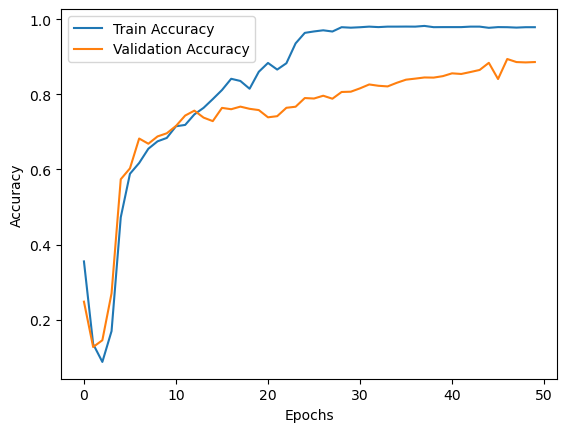

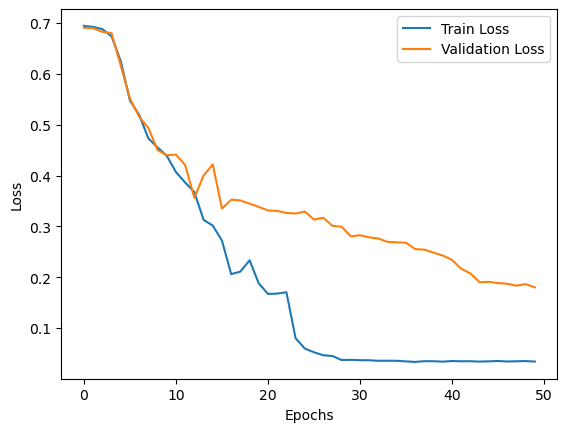

In [28]:

plt.plot(train_accs, label='Train Accuracy')
plt.plot(vail_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(vail_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:

# PATH = "Digital.pth"
# torch.save(model.state_dict(), PATH)

In [29]:
"""Test images"""
total = 0
correct = 0
f1s = []
test_precisions = []
test_recalls = []
test_losses = []
test_accs = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred = model(inputs)
        predicted_probs = F.softmax(pred, dim=1)
        _, predicted = torch.max(pred, 1)

        loss = cross_entropy(pred, labels)  
        test_losses.append(loss.cpu().detach().numpy())
        acc, precision, recall = score(predicted, labels)
        
        f1 = 2 * precision * recall / (precision + recall)
        f1s.append(f1)
        test_precisions.append(precision)
        test_recalls.append(recall)
        test_accs.append(acc)

        total += labels.size(0)
        correct += (predicted == labels).sum()
        
f1_score = sum(f1s)/len(f1s)
loss = sum(test_losses)/len(test_losses)
recall = sum(test_recalls)/len(test_recalls)
precision = sum(test_precisions)/len(test_precisions)
acc = sum(test_accs)/len(test_accs)
print(f"batch:{total}, acc: {acc}, auc: {correct / total * 100}, recall: {recall}, precision: {precision}, f1-score: {f1_score}")

batch:279, acc: 0.9056389576764683, auc: 89.96415710449219, recall: 0.9113876319758673, precision: 0.8865376453611747, f1-score: 0.8956747367858477


<Axes: >

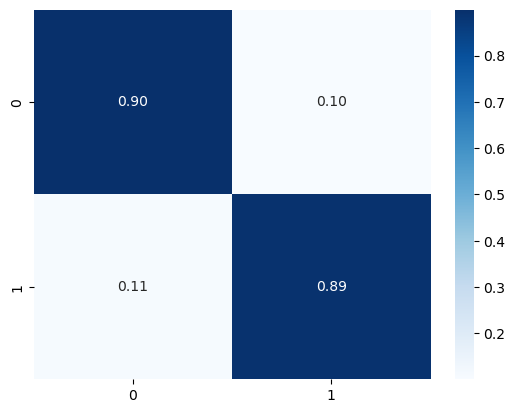

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.cpu().numpy().tolist()


labels = ['0', '1',] 
cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

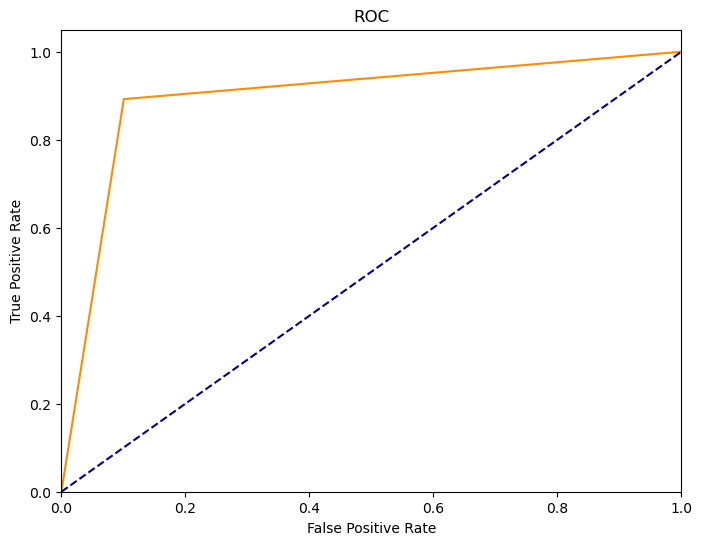

In [40]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC ' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

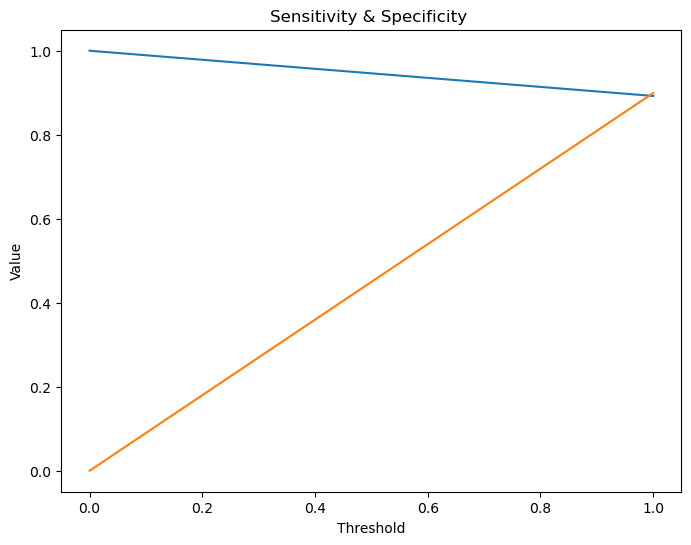

In [41]:

sensitivity = tpr
specificity = 1 - fpr

plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity, label='Sensitivity')
plt.plot(thresholds, specificity, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Sensitivity & Specificity ')
plt.show()

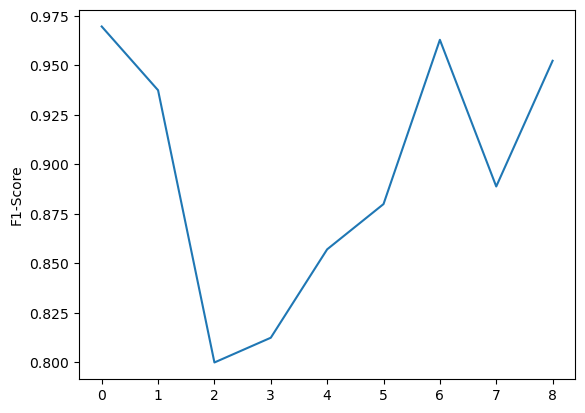

In [31]:

plt.plot(range(len(f1s)), f1s)
plt.ylabel("F1-Score")
plt.show()

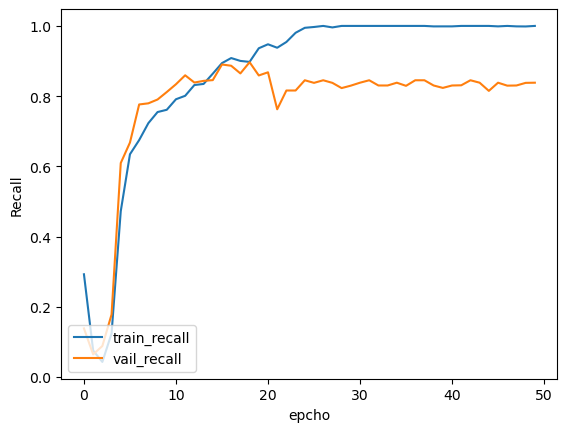

In [ ]:

plt.plot(range(len(train_recalls)), train_recalls, label="train_recall")
plt.plot(range(len(vail_recalls)), vail_recalls, label="vail_recall")
plt.xlabel("epcho")
plt.ylabel("Recall")
plt.legend(loc="lower left")
plt.show()

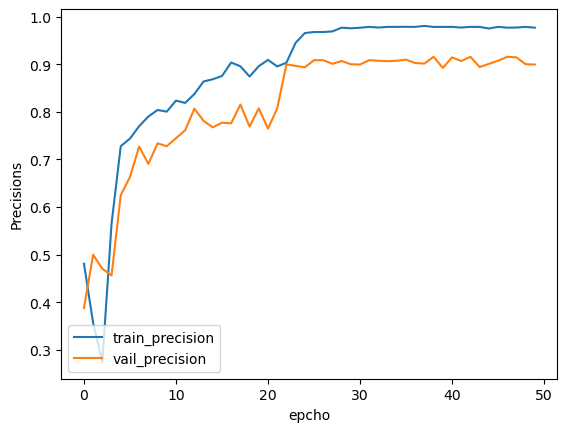

In [33]:

plt.plot(range(len(train_precisions)), train_precisions, label="train_precision")
plt.plot(range(len(vail_precisions)), vail_precisions, label="vail_precision")
plt.xlabel("epcho")
plt.ylabel("Precisions")
plt.legend(loc="lower left")
plt.show()

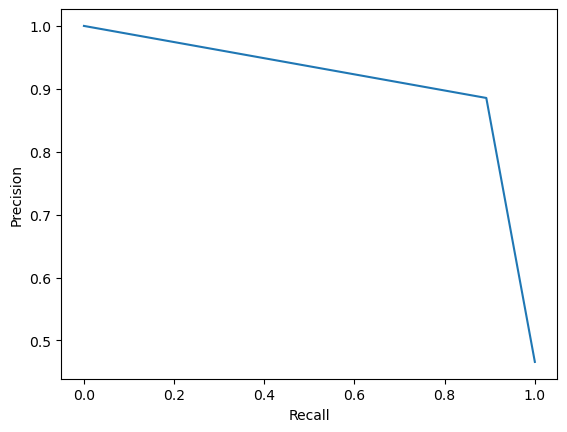

In [42]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# PR
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()